# **Практика: SHAP for ML models**

Привет, друзья! Рады видеть вас на второй практической части модуля. Теперь в копилке наших методов ещё один — SHAP.

На основе знаний из прошлого урока вы помните, что **SHAP** — метод адаптивный, от чего он является еще и частоиспольуземым. Однако, у значений Шепли есть еще одна причина, по которой их стоит любить — безумно красивый процесс интерпретации.

Работать будем с тем же набором данных, что и в прошлом модуле — калифорнийские дома. Напомним, что каждая строка в наборе данных отражает отдельный жилой район и содержит информацию о средних характеристиках домов в этом районе.

**Основные характеристики:**

**Целевая переменная (target):**

- `MedHouseVal` — средняя стоимость домов в данном районе, выраженная в сотнях тысяч долларов.

**Признаки (features):**

- `MedInc` (Median Income): медианный доход в районе (в десятках тысяч долларов)

- `HouseAge` (Housing Median Age): медианный возраст домов в районе (в годах)
- `AveRooms` (Average Rooms per Dwelling): среднее количество комнат на одно жилье.
- `AveBedrms` (Average Bedrooms per Dwelling): среднее количество спален на одно жилье.
- `Population (Population):` численность населения в районе.
-  `AveOccup (Average Occupancy):` среднее количество жильцов на одно жилище.
-  `Latitude (Latitude):` географическая широта района.
- `Longitude (Longitude):` географическая долгота района.

В отличие от прошлой практической части, будем использовать модель CatBoost. Надеемся, эта практика будет для вас интересной и визуально приятной! \

Приступим! Приятного кодинга!


In [1]:
#установим необходимые библиотеки
!pip install shap catboost -q

In [4]:
import tqdm as notebook_tqdm

In [5]:
import catboost
import pandas as pd
import numpy as np
import shap
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


data = pd.read_csv('https://github.com/SadSabrina/explainable_AI_course/raw/refs/heads/main/data/fetch_california_housing.csv',
                   index_col=0)

X, y = data.drop('target', axis=1), data['target']

rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 1, X.shape[0]), name="rnd_bin")
num_var = pd.Series(np.arange(X.shape[0]), name="rnd_num")

X_with_rnd_feat = pd.concat((X, bin_var, num_var), axis=1)

Как прежде — сразу обучим модель на имеющихся данных. Однако, в этот раз мы пропускаем процесс нормализации признаков.

**Quiz 1: Почему процесс нормализации может быть опущен?**

Корректное использование модели (Gradient boosting) не требует нормализации данных

In [6]:
#разобьем данные на train и test

X_train, X_test, y_train, y_test = train_test_split(
    X_with_rnd_feat, y, random_state=42
)

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
model.fit(X_train, y_train, verbose=False, plot=False)

model.best_score_

{'learn': {'RMSE': 0.3942466252654654}}

## **Анализ индивидуальных прогнозов при помощи SHAP**

1. **Force plot.**

Дословно данный тип графика отражает *силу* влияния конкретного значения признака на прогноз модели. Для большей детализации график окрашен голубым (понижение прогноза модели) и красным (увеличение прогноза модели) цветами.


**Для любого одного наблюдения force plot позволяет увидеть:**
- среднее значение целевого признака (вернее, матожидание) *по изначальным входным данным*
- значения конкретных переменных, участвовавших в прогнозировании целевого значения для признака
- силу и направление вклада конкретных значений признаков на изменение прогноза от среднего

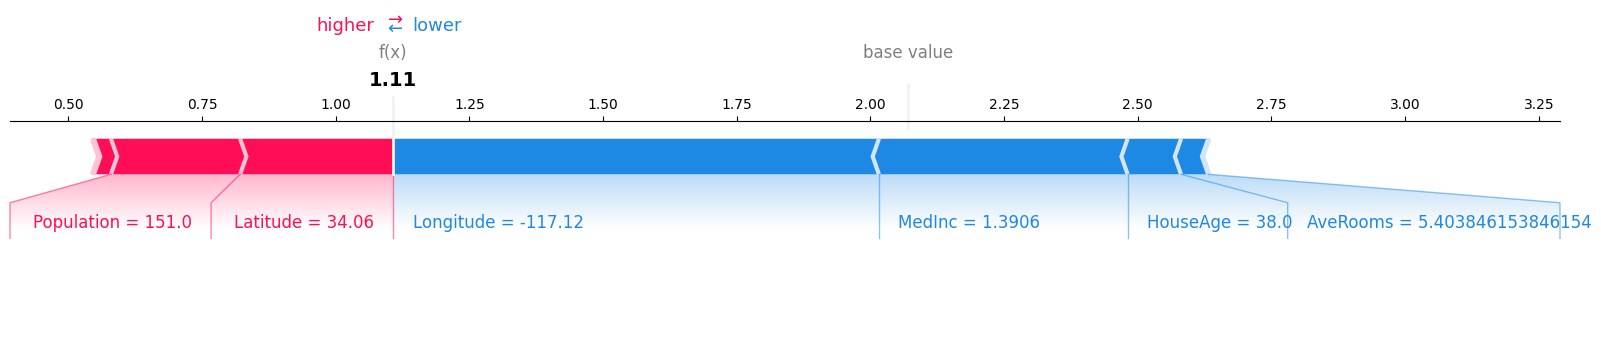

In [ ]:
# shap.initjs()
import matplotlib
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

# Визуализируем прогнозы для 7-го объекта в тренировочных данных
shap.plots.force(shap_values[7, :], matplotlib=matplotlib)

Детализировать force plot до конкретных значений помогает waterfall plot.

Единнственный минус `force_plot` — невозможность оценить конкретные значения Шепли. Однако, чтобы устранить это, мы можем детализировать `force_plot` при помощи `waterfall_plot`

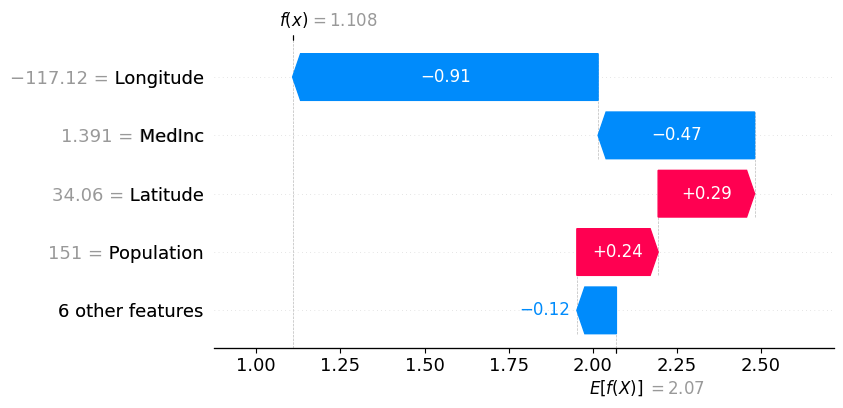

In [11]:
# Визуализируем прогнозы для 7-го объекта в тренировочных данных
shap.plots.waterfall(shap_values[7, :], max_display=5)

Или `bar` plot.

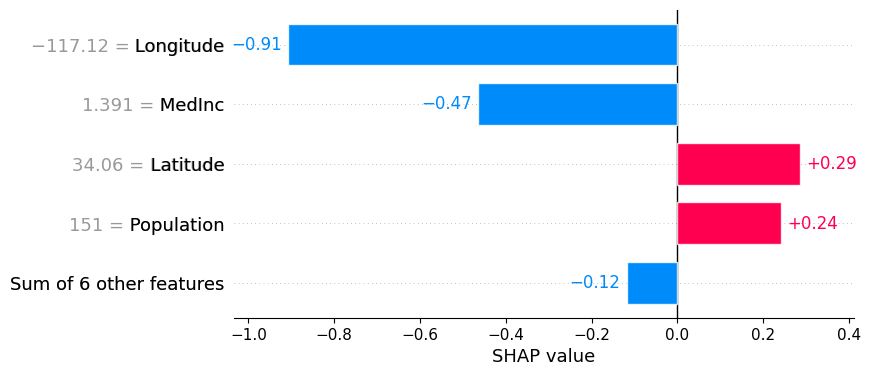

In [12]:
shap.plots.bar(shap_values[7], max_display=5)

**Quiz 2: Постройте аналогичный график для наблюдения с индексом 7 в тестовом наборе данных тестового набора данных. После, выделите жирным шрифтом верные утверждения ниже.**

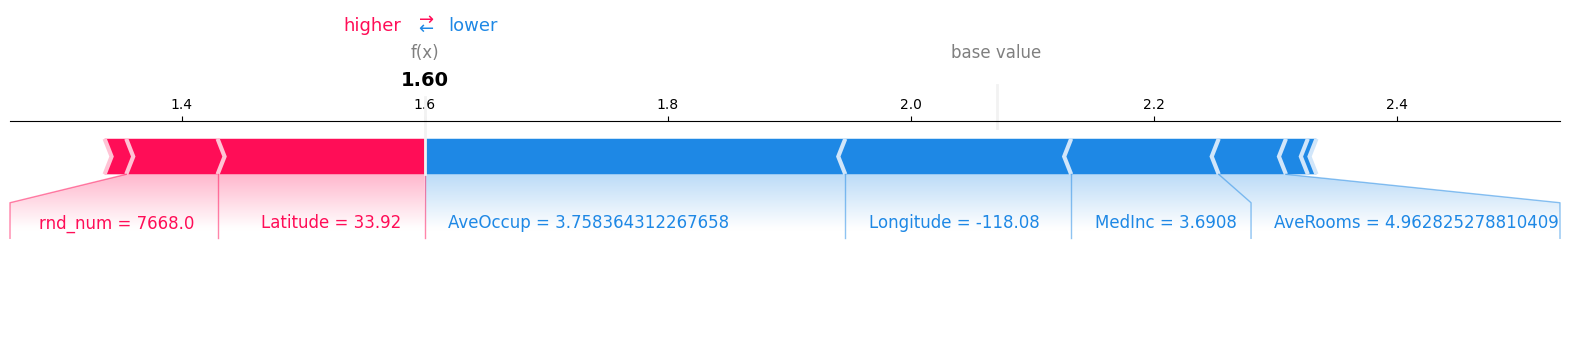

In [14]:
# Ваш код здесь
explainer_t = shap.TreeExplainer(model)
shap_values_t = explainer(X_test)

# Визуализируем прогнозы для 7-го объекта в тренировочных данных
shap.plots.force(shap_values_t[7, :], matplotlib=matplotlib)

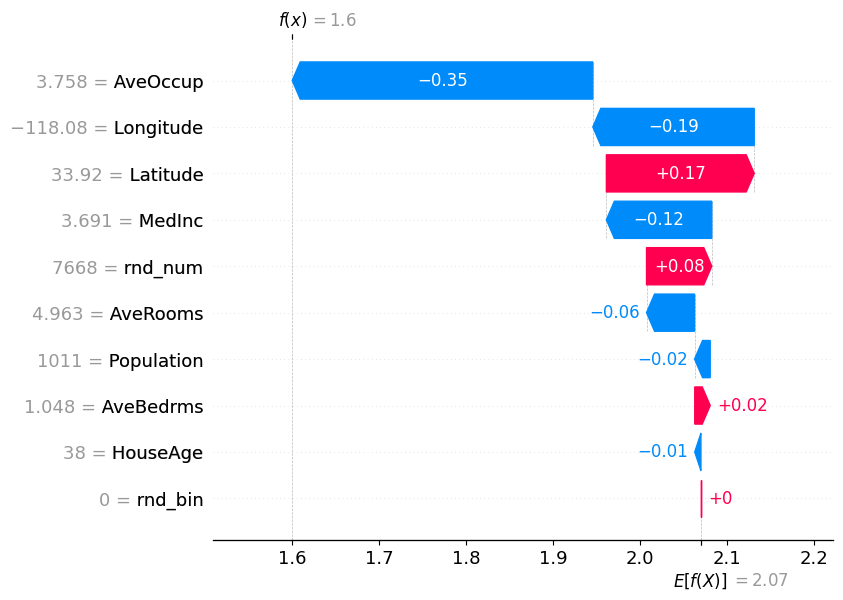

In [16]:
# Визуализируем прогнозы для 7-го объекта в тренировочных данных
shap.plots.waterfall(shap_values_t[7, :], max_display=10)

Выделите жирным верные утверждения:
- **В построении прогноза для объекта были задействованы 6 признаков**
- Среднее значение MedInc, прогнозируемое алгоритмом для X_test = 2.063
- **Прогноз модели для данного объекта равен 1.6**
- Latitude привел к увеличению прогноза от базового на 33.92
- **Признаков, уменьшавших прогноз от базового значения 4**



Если график выше повернуть на 90 градусов и сложить, то получится следующая картинка

In [21]:
from IPython.display import display, HTML

In [27]:
!pip install 'shap==0.25.1' --force-reinstall

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numpy-2.2.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached matplotlib-3.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached pandas-2.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached ipython-8.34.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached decorator-5.2.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached exceptiongroup-1.2.2-py3-none-any.whl.metadata (6.6 kB)
  Using cached jedi-0.19.2-py

In [28]:
shap.initjs()
force_plot = shap.plots.force(shap_values[7:9,]) #сложенный график для двух наблюдений
shap_html = f"<head>{shap.getjs()}</head><body>{force_plot.html()}</body>"
display(HTML(shap_html))

Для больших бессвязных сегментов в наборе данных график не очень информативен (ради интереса, попробуйте получить график для большого количества значений или обратитессь к примеру ниже). С точки зрения практики здесь для нас оказывается полезным то, что этот график может оказаться полезынм при рассмотрении отдельных признаков.

## **Анализ глобального поведения модели при помощи SHAP**

In [30]:
shap.initjs()

#Посмотрим на график для первых 100 объектов тренировочного набора данных
shap.plots.force(shap_values[:100])

Выбирая отдельные шкалы на осях x и y, мы можем увидеть основную тендецию влияния признака для всех наборов данных. Например, выбрав слева и сверху MedInc effects и MedInc соответственно, можно увидеть, что данный признак способен как увеличивать, так и уменьшать прогноз от его матожидания.

**Quiz 3: Постройте суммарный force plot для первых 100 объектов из тестового набора данных. Выделите жирным шрифтом верные утверждения.**

In [31]:
shap.initjs()

#Ваш код здесь
shap.plots.force(shap_values_t[:100])

Выделите верные утверждения для выбранных 100 объектов:
- **Признак, увеличивающий прогноз от базового чаще всех Population**
- Признак, увеличивающий прогноз от базового чаще всех MedInc
- **Признак, уменьшающий от базового чаще всех Latitude**

**Quiz 4: Проверьте, оказывает ли на модель влияние случайный признак `rnd_num`?, а `rnd_bin`?**

Дальше, мы можем попробовать посмотреть, существует ли явное парное взаимодейтсвие признаков. Оно называется *feature interaction*.

Взаимодействием признаков называют комбинированный эфект двух или более признаков на целевую переменную. Другими словами, взаимодействие происходит, когда эффект одного признака на целевую переменную зависит от значения другого признака.

Пример парного взаимодействия зависимость цены дома от площади. Например, большая площадь может вести к бОльшей цене, но явный эффект такого поведения наблюдается только для молодых домов.  

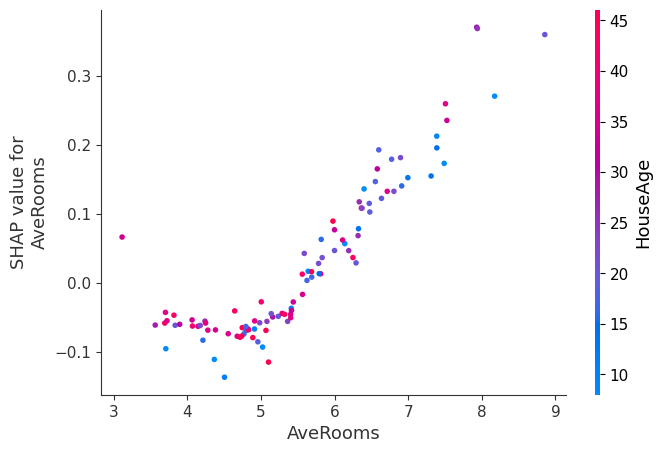

In [32]:
# Создадим dependence plot для рассмотрения влияния пары признаков на выход модели
shap.dependence_plot("AveRooms", shap_values.values[:100], X_train[:100], interaction_index="HouseAge")

Разберемся с осями графика.
- Левая шкала отражает значение Шепли. Внимательно смотрите на диапазоны изменения значений, чтобы не извлечь ошибочный вывод. Например, может показаться, что для старших домов маленькое среднее количество комнат снижает цену, но это не так. На самом деле, чем старше дом, тем меньше эффекта от среднего количества комнат на дом.
- Правая и нижняя шкалы отражают признаки, взаимодействие которых мы рассматриваем.



**Quiz 5: Постройте `dependence_plot` для тех же признаков, для первых 100 объектов, но на основе test_explainer и test_shap_values. Выберите верные утверждения на степик.**

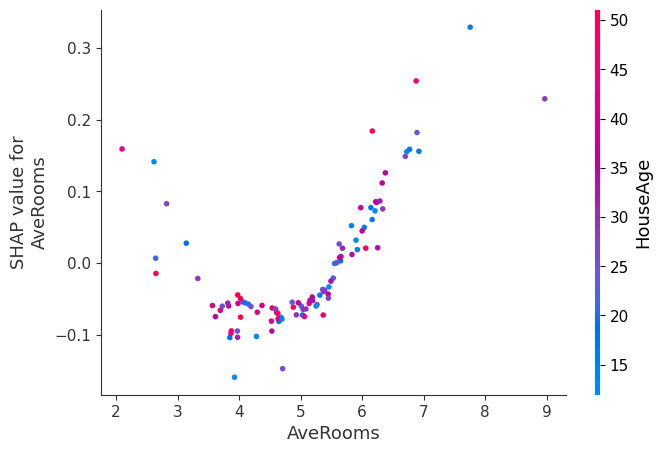

In [33]:
# Ваш код здесь
# Создадим dependence plot для рассмотрения влияния пары признаков на выход модели
shap.dependence_plot("AveRooms", shap_values_t.values[:100], X_test[:100], interaction_index="HouseAge")

И так, мы с вами рассмотрели влияния одного и комбинации из двух признаков на поведение модели. Теперь рассмотрим логическое завершение — средний вклад каждого в прогноз.  

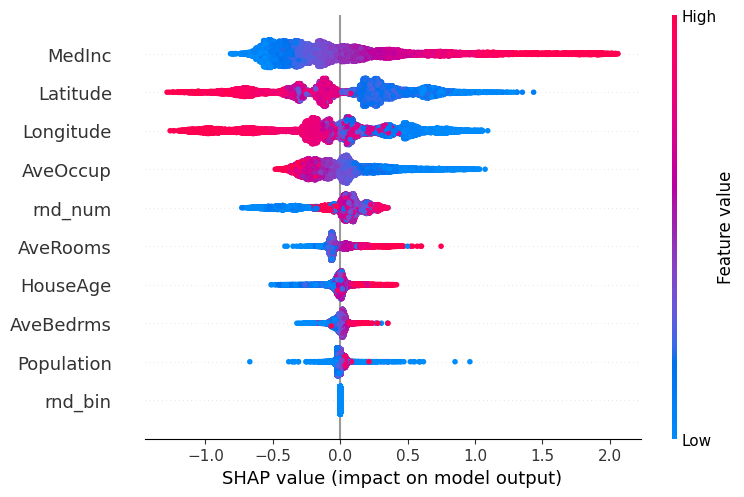

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

Данный график позволяет получить выводы об обобщенном влиянии каждого признака. Так, например мы можем увидеть, что:
- Ширина и долгота (расположение) увеличиваясь ведут к уменьшению прогноза;
- Чем больше медианный доход, тем сильнее повышается вклад в медианную стоимость домов.
- Большие значения Population практически не оказывают влияния на модель
- Большое среднее количество спален способно немного влиять на модель

**Quiz 6: постройте аналогичный график для тестовых данных. Остаются ли верными выводы выше для тестового набора?**


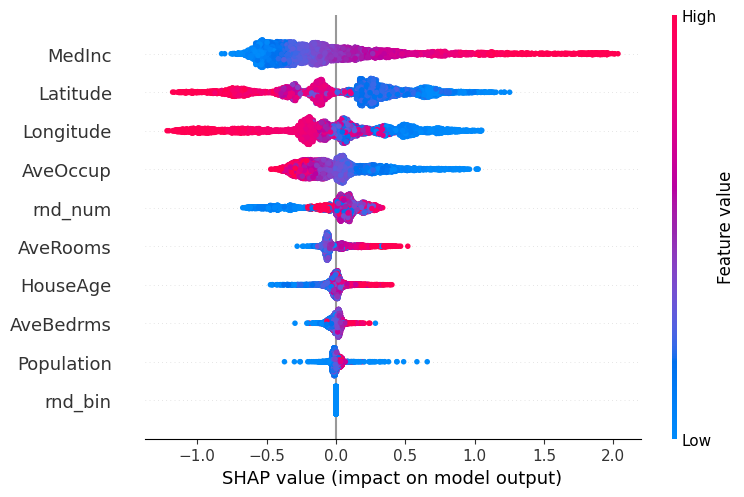

In [ ]:
#Ваш код здесь
shap.plots.beeswarm(shap_values_t)

- Медианный доход практически линейно связан со значениями Шепли (чем больше медианный доход, чем выше значение Шепли)
- Чем меньше среднее количество жильцов, тем больше значение Шепли
- Случайный признак имеет логически читаемую взаимосвязь (маленькие значения ведут к маленьким значениями Шеппли).
- У ширины и долготы похожие силуэты влияния, следовательно этих два признака связяны (так НЕ надо)
- Существует наблюдение, где маленькое среднее значение комнат на жилье привело к увеличению значения Шеппли.

Иной способ прдеставления суммарной важности, ее представление в виде столбчатой диаграммы. Обратите внимание, что на ней берется среднее значение по **модулю коэффициентов** Шепли.

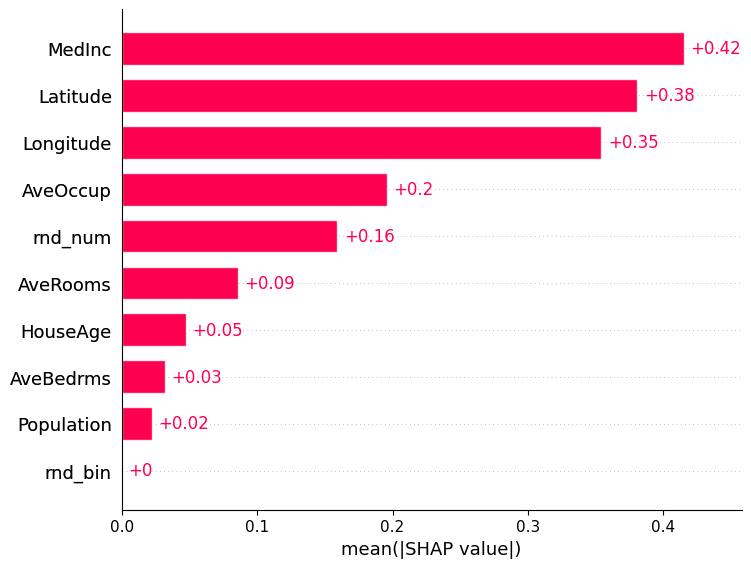

In [35]:
# summarize the effects of all the features
shap.plots.bar(shap_values)

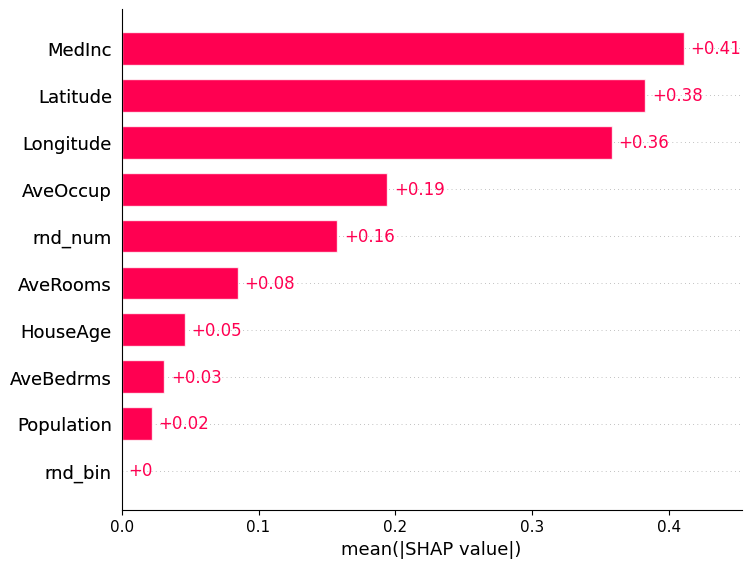

In [36]:
shap.plots.bar(shap_values_t)

**Quiz 7: Какая информация теряется, при анализе столбчатого графика?**

И послений тип визуализации на сегодня — тепловая карта. Её мы приводим просто для ознакомления, так как не зная предыдущей логики графиков, читать её — сложно. Однако, на основе изученного можно видеть, что такая карта — хорошее обобщение для почти всех вохможных выводов из коэффициентов Шепли.

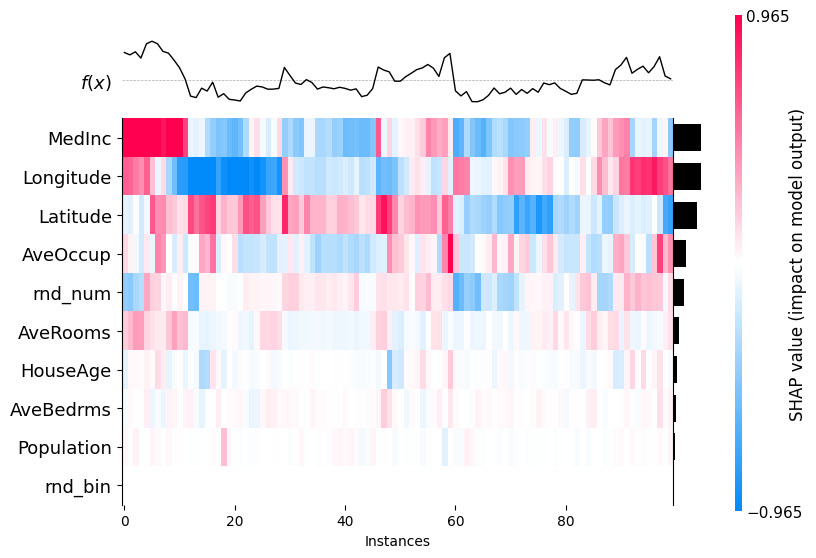

<Axes: xlabel='Instances'>

In [ ]:
# визуализация в виде тепловой карты
shap.plots.heatmap(shap_values[:100])

-